# **Ex3 - Unsupervised learning**

## Names and IDs

1.   Omer Rosenberg 315328898
2.   Chen Harel 205566292


In this assignemnt you will practice unsupervised methods we saw in class, and specifically running K-means and visualizing the data using PCA.

In this assignment you will learn a few more things:

1.   Load local files
2.   Load data from Kaggle
3. Use Scikit-learn K-means
4. Use Scikit-learn PCA
5. Some visulaization
6. Evaluate the performance of the clustering using Elbow methods, Siouhette analysis and accuracy (as we have true labels)

Note:
* Read the complete task before implementing.
* Reuse code, write functions.

## Import All Packages
Add all imports needed for this notebook to run

In [1]:
# Implement here
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from keras.datasets import mnist

# Text Clustering And Dimension Reduction

In this exercise you will cluster fake news using `k-means` and visualize the clustering using PCA.

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [2]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes
 46% 19.0M/41.0M [00:00<00:00, 196MB/s]
100% 41.0M/41.0M [00:00<00:00, 200MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


## 1. Read the csv files and create one single dataframe (5 points)

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [3]:
# Example for reading one file. It will work if the previous step was successful.
fake = pd.read_csv('/content/Fake.csv')
true = pd.read_csv('/content/True.csv')
fake['Label']= 0
true['Label']= 1
merged = pd.concat([fake, true], ignore_index= True)
text_labels = merged[['text', 'Label']]

# Testing if the joined dataframe length is equal to the addition of the 2.
assert len(fake)+len(true) == len(merged)

## 2. Cluster the samples into 2 clusters (real and fake) (15 points)

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`).
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [4]:
# tf_idf vectorizer with no stopwords
vectorizer = TfidfVectorizer(max_features = 1000, stop_words = 'english')
vect_res = vectorizer.fit_transform(text_labels['text'])

#scaling the data 
scaler = StandardScaler(with_mean=False)
scale_res = scaler.fit_transform(vect_res)

#Kmenas
kmeans = KMeans(n_clusters=2, random_state = 205566292)
kmeans_prediction = kmeans.fit_predict(scale_res)

## 3. Visualize using scatter plot (20 points)
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction suing PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

Notes:

*   In clustering visualization it's important to also visualize the centroids.
* Visualize using matplotlib scatter function. It can be used to plot 2D or 3D scatter plots.

Text(0.5, 1.0, '2D Visualization')

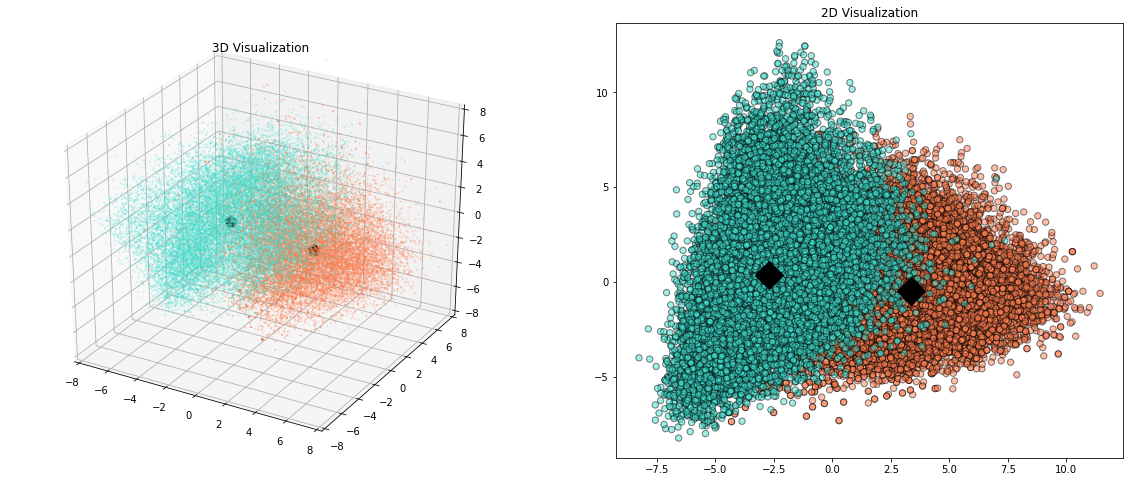

In [5]:
# merging all points with the 2 centers.
scale_res_with_centers = list(scale_res.toarray()) + list(kmeans.cluster_centers_)

fig = plt.figure(figsize = (20,8))

#3D
pca_3D = PCA(n_components = 3)
reduced_3D_pca = pca_3D.fit_transform(scale_res_with_centers)
centers_3D = reduced_3D_pca[-2:]
points_3D = reduced_3D_pca[:-2]

ax_3D = fig.add_subplot(1,2,1, projection='3d')
ax_3D.scatter(points_3D[:,0],points_3D[:,1],points_3D[:,2], c=text_labels['Label'], cmap = matplotlib.colors.ListedColormap(['coral','turquoise']), s=1, alpha = 0.2)
ax_3D.scatter(centers_3D[:,0], centers_3D[:,1], centers_3D[:,2], marker="p", color='k' ,s = 150, alpha=1,edgecolor = "k")
plt.xlim(-8,8)
plt.ylim(-8,8)
ax_3D.set_zlim(-8,8)
ax_3D.set_title("3D Visualization")


#2D
pca_2D = PCA(n_components = 2)
reduced_2D_pca = pca_2D.fit_transform(scale_res_with_centers)
centers_2D = reduced_2D_pca[-2:]
points_2D = reduced_2D_pca[:-2]

ax_2D = fig.add_subplot(1,2,2)
ax_2D.scatter(points_2D[:,0],points_2D[:,1], c=text_labels['Label'], cmap = matplotlib.colors.ListedColormap(['coral','turquoise']), edgecolor='k', s=40, alpha = 0.5)
ax_2D.scatter(centers_2D[:,0], centers_2D[:,1], marker="D", color='k',s = 400)
ax_2D.set_title("2D Visualization")


## 4. Performance evaluation (15 points)
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [6]:
#Cluster 1: FAKE Cluster 2: TRUE
opt1 = accuracy_score(text_labels['Label'], kmeans_prediction)
print('Cluster 1: FAKE Cluster 2: TRUE, Accuracy: ' + str(opt1))
#Cluster 1: TRUE Cluster 2: FAKE
opt2 = accuracy_score(text_labels['Label'], 1 - kmeans_prediction)
print('Cluster 1: TRUE Cluster 2: FALSE, Accuracy: ' + str(opt2))

#update prediction
kmeans_prediction = 1 - kmeans_prediction

Cluster 1: FAKE Cluster 2: TRUE, Accuracy: 0.12775624749432046
Cluster 1: TRUE Cluster 2: FALSE, Accuracy: 0.8722437525056795


## 5. Find optimal `k` (20 points)
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.

Notes:
* You can get the SSD of a clustering using the `inertia_` attribute of the model.
* Silhouette score using `silhouette_score` function from `sklearn.metrics`. This function accept the model and the data.

In [7]:
#CALCULATE
Silhouette_scores = []
SSD_scores = []
Kmeans_models = []
for k in range(2, 21):
  kmeans = KMeans(n_clusters=k, random_state = 205566292)
  kmeans_prediction = kmeans.fit_predict(scale_res)
  Kmeans_models.append(kmeans)
  Silhouette_scores.append(silhouette_score(scale_res, kmeans_prediction))
  SSD_scores.append(kmeans.inertia_)


Text(0.5, 0, 'K Value')

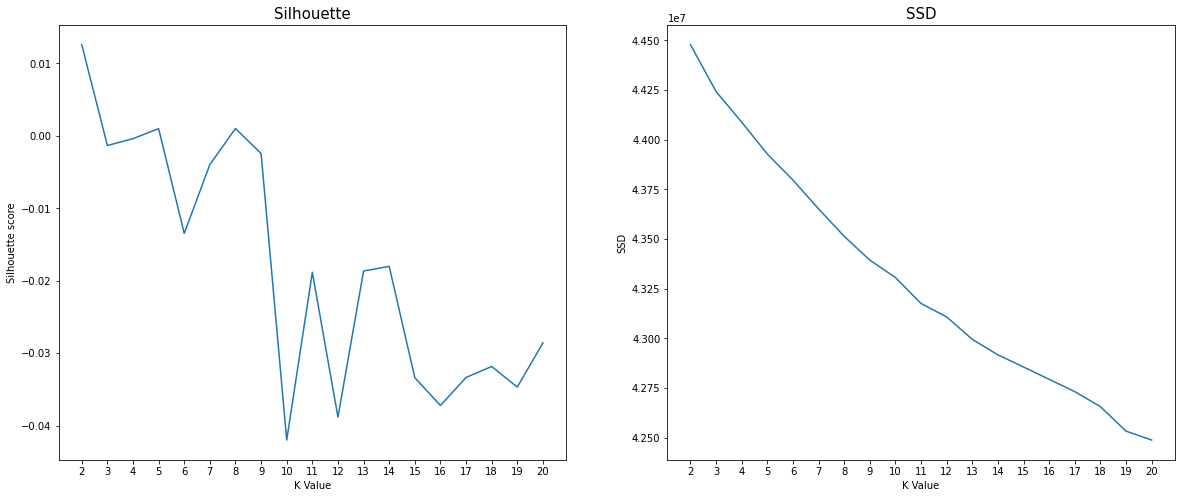

In [8]:
#PLOT
fig = plt.figure(figsize = (20,8))
k_values = range(2,21)

#Silhouette
ax1 = fig.add_subplot(1,2,1)
ax1.plot(k_values , Silhouette_scores)
plt.xticks(k_values)
plt.title('Silhouette', fontsize = 15)
plt.ylabel('Silhouette score')
plt.xlabel('K Value')
#SSD
ax2 = fig.add_subplot(1,2,2)
ax2.plot(k_values , SSD_scores)
plt.xticks(k_values)
plt.title('SSD', fontsize = 15)
plt.ylabel('SSD')
plt.xlabel('K Value')


### 6. What is the optimal k for clustering? (10 points)

* Explain.
* If optimal k!=2 what can be a good explanation for this?

The optimal k according to our data is 2, we can see it with both metrices. \
**Silhouette:**\
as you can see at the charts above, the maximum silhouette value is at k = 2. \
As we learned in class, we want the coefficient to be as big as possible(closest to 1) to have good clusters.\
**SSD:**\
As we learned in class, we need to search the point on the k-values which beyond it the trend of the line is linear.\
As you can see the whole trend is linear in our plot, so we can conclude that the point mentioned above is the point where k=2.

# 7. PCA then k-means (15 points)
This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.


Text(0.5, 0.01, 'Accuracy: 0.8722437525056795')

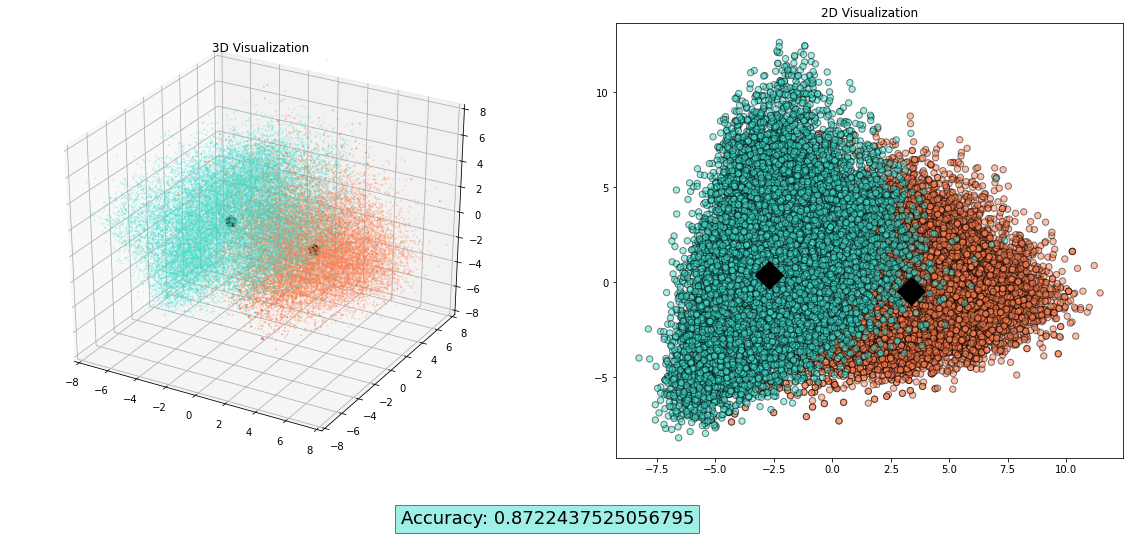

In [9]:
#PCA
pca = PCA(n_components = 1000)
pca_res = pca.fit_transform(scale_res.toarray())

#Kmeans
kmeans_no_limit = KMeans(n_clusters=2, random_state = 205566292)
kmeans_no_limit_prediction = kmeans_no_limit.fit_predict(pca_res)
centers_no_limit = kmeans_no_limit.cluster_centers_
accuracy_no_limit = 1-accuracy_score(text_labels['Label'], kmeans_no_limit_prediction)

# merging all points with the 2 centers.
pca_no_limit_res_wcenters = list(pca_res) + list(centers_no_limit)

fig = plt.figure(figsize = (20,8))
#3D
  #PCA
pca_3D = PCA(n_components = 3)
reduced_3D_pca = pca_3D.fit_transform(pca_no_limit_res_wcenters)
centers_3D = reduced_3D_pca[-2:]
points_3D = reduced_3D_pca[:-2]
  #PLOT
ax_3D = fig.add_subplot(1,2,1, projection='3d')
ax_3D.scatter(points_3D[:,0],points_3D[:,1],points_3D[:,2], c=text_labels['Label'], cmap = matplotlib.colors.ListedColormap(['coral','turquoise']), s=1, alpha = 0.2)
ax_3D.scatter(centers_3D[:,0], centers_3D[:,1], centers_3D[:,2], marker="p", color='k' ,s = 150, alpha=1,edgecolor = "k")
plt.xlim(-8,8)
plt.ylim(-8,8)
ax_3D.set_zlim(-8,8)
ax_3D.set_title("3D Visualization")

#2D
  #PCA
pca_2D = PCA(n_components = 2)
reduced_2D_pca = pca_2D.fit_transform(pca_no_limit_res_wcenters)
centers_2D = reduced_2D_pca[-2:]
points_2D = reduced_2D_pca[:-2]
  #PLOT
ax_2D = fig.add_subplot(1,2,2)
ax_2D.scatter(points_2D[:,0],points_2D[:,1], c=text_labels['Label'], cmap = matplotlib.colors.ListedColormap(['coral','turquoise']), edgecolor='k', s=40, alpha = 0.5)
ax_2D.scatter(centers_2D[:,0], centers_2D[:,1], marker="D", color='k',s = 400)
ax_2D.set_title("2D Visualization")


plt.figtext(0.5, 0.01, "Accuracy: " + str(accuracy_no_limit), ha="center", fontsize=18, bbox={"facecolor":"turquoise", "alpha":0.5, "pad":5})

# 7
As we can see we get the same accuracy.\
We can conclude that the transformation the PCA does on all the features 
doesn't affect the clustering process of the KMeans.


# Bonus (10 points)
Redo the same analysis, but this time using the MNIST data set. Notice that this time there are actually 10 'true' clusters.

1. What is the accuracy of the clustering when using k=10?
2. What is the optimal k?
3. How do the results changes if you first run PCA?

In [10]:
# MNIST figures data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = train_x.reshape(len(train_x),-1)

# kmeans
mnist_kmeans = KMeans(n_clusters=10,random_state=205566292)
model = mnist_kmeans.fit(train_x)



11501568/11490434 [==============================] - 0s 0us/step


Text(0.5, 1.0, '2D Visualization')

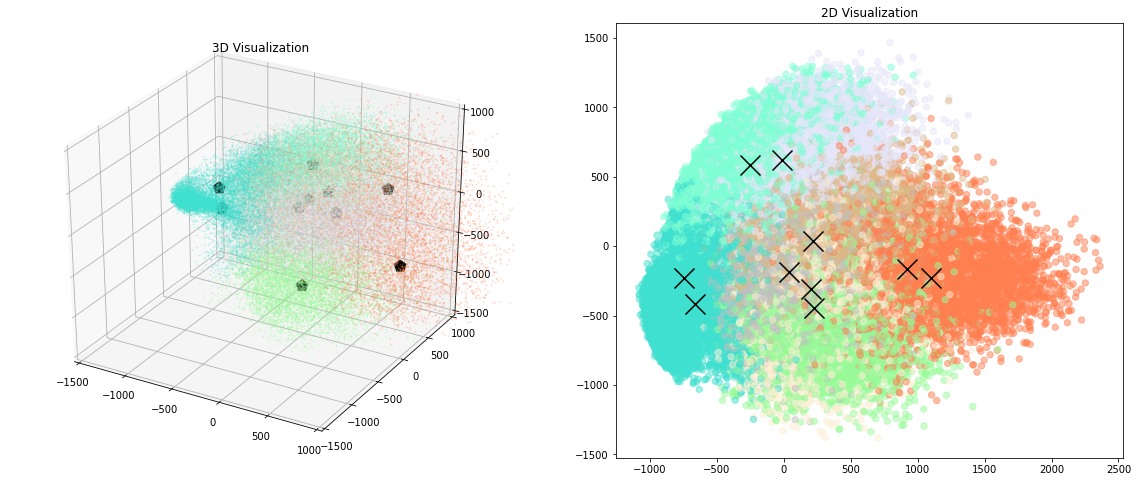

In [18]:
# merging all points with the 10 centers.
all_points = list(train_x) + list(mnist_kmeans.cluster_centers_)
colors = ['coral','turquoise','papayawhip','palegreen','orchid','lavender','lightpink','burlywood','aquamarine','silver']
fig = plt.figure(figsize = (20,8))

#3D
pca_3D = PCA(n_components = 10)
reduced_3D_pca = pca_3D.fit_transform(all_points)
centers_3D = reduced_3D_pca[-10:]
points_3D = reduced_3D_pca[:-10]

ax_3D = fig.add_subplot(1,2,1, projection='3d')
ax_3D.scatter(points_3D[:,0],points_3D[:,1],points_3D[:,2], c=mnist_kmeans.labels_, cmap = matplotlib.colors.ListedColormap(colors), s=1, alpha = 0.2)
ax_3D.scatter(centers_3D[:,0], centers_3D[:,1], centers_3D[:,2], marker="p", color='k' ,s = 150, alpha=1,edgecolor = "k")
plt.xlim(-1500,1000)
plt.ylim(-1500,1000)
ax_3D.set_zlim(-1500,1000)
ax_3D.set_title("3D Visualization")


#2D
pca_2D = PCA(n_components = 2)
reduced_2D_pca = pca_2D.fit_transform(all_points)
centers_2D = reduced_2D_pca[-10:]
points_2D = reduced_2D_pca[:-10]

ax_2D = fig.add_subplot(1,2,2)
ax_2D.scatter(points_2D[:,0],points_2D[:,1], c=mnist_kmeans.labels_, s=40, alpha = 0.5, cmap = matplotlib.colors.ListedColormap(colors) )
ax_2D.scatter(centers_2D[:,0], centers_2D[:,1], marker="x", color='k',s = 400)
ax_2D.set_title("2D Visualization")

In [13]:
from collections import Counter
'''
Accuracy
We'll need to find the true labels of the kmeans_lables_ result, beacause its just an arbitrary cluster number.
Inorder to do that we'll use majority vote for each cluster, to look for the most likely number.
'''
def clusters_true_label(true_labels, cluster_labels):
  new_labels = cluster_labels
  dict_of_labels = {}

# Generating dict of {cluster # : [true_label,true_label,true_label]}
  for i in range(len(cluster_labels)):
    if not new_labels[i] in dict_of_labels.keys():
      dict_of_labels[new_labels[i]] = []

    dict_of_labels[new_labels[i]] += [true_labels[i]]

# Majority
  for c in dict_of_labels.keys():
    dict_of_labels[c] = Counter(list(dict_of_labels[c])).most_common(1)

# Replacing labels to the most common ones in the dict
  for i in range(len(new_labels)):
    new_labels[i] = dict_of_labels[new_labels[i]][0][0]

  return new_labels


In [14]:
# Setting up new lables
labels = clusters_true_label(train_y,mnist_kmeans.labels_)
# accuracy
accuracy = accuracy_score(train_y,labels)
print('KMeans model accuracy is : '+str(accuracy))


KMeans model accuracy is : 0.5909833333333333


In [15]:
#Optimal K

Silhouette_scores = []
SSD_scores = []
Kmeans_models = []
for k in [2,4,6,8,10,12,14,16,18,20]:
  kmeans = MiniBatchKMeans(n_clusters=k, random_state = 205566292,batch_size=100)
  kmeans_prediction = kmeans.fit_predict(train_x)
  Kmeans_models.append(kmeans)
  Silhouette_scores.append(silhouette_score(train_x,  clusters_true_label(train_y,kmeans_prediction)))
  SSD_scores.append(kmeans.inertia_)

Text(0.5, 0, 'K Value')

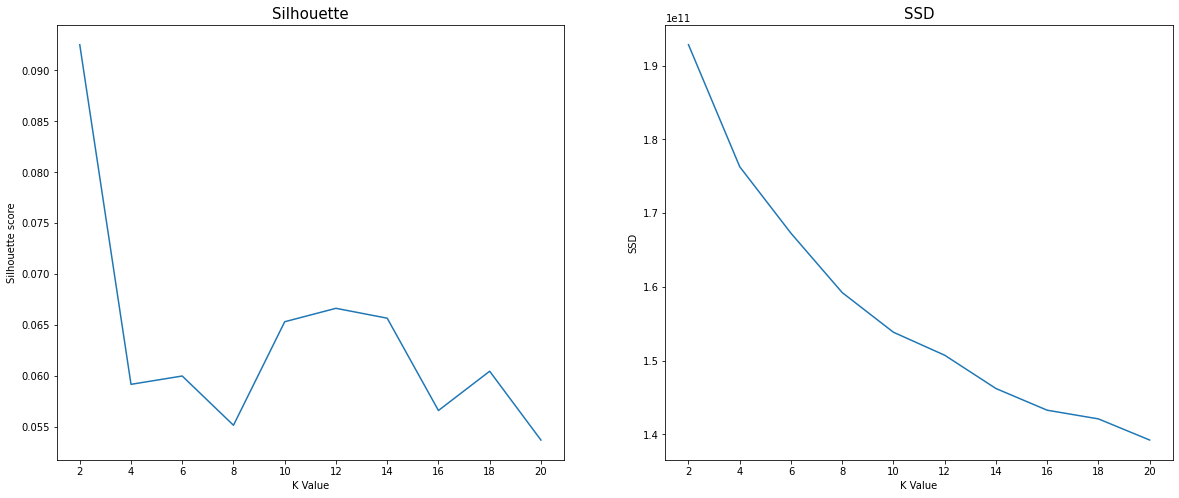

In [16]:
#PLOT
fig = plt.figure(figsize = (20,8))
k_values = [2,4,6,8,10,12,14,16,18,20]

#Silhouette
ax1 = fig.add_subplot(1,2,1)
ax1.plot(k_values , Silhouette_scores)
plt.xticks(k_values)
plt.title('Silhouette', fontsize = 15)
plt.ylabel('Silhouette score')
plt.xlabel('K Value')
#SSD
ax2 = fig.add_subplot(1,2,2)
ax2.plot(k_values , SSD_scores)
plt.xticks(k_values)
plt.title('SSD', fontsize = 15)
plt.ylabel('SSD')
plt.xlabel('K Value')

We think the optimal k according to our data is 10. \
**Silhouette:**\
as you can see at the charts above, the maximum silhouette value is at k = 2. \
but also a local maximum near k = 10/12.\
**SSD:**\
As we learned in class, we need to search the point on the k-values which beyond it the trend of the line is linear.\
As we can see at k = 10 there is some elbow which after it the trend is linear

Text(0.5, 0.01, 'Accuracy: 0.5909833333333333')

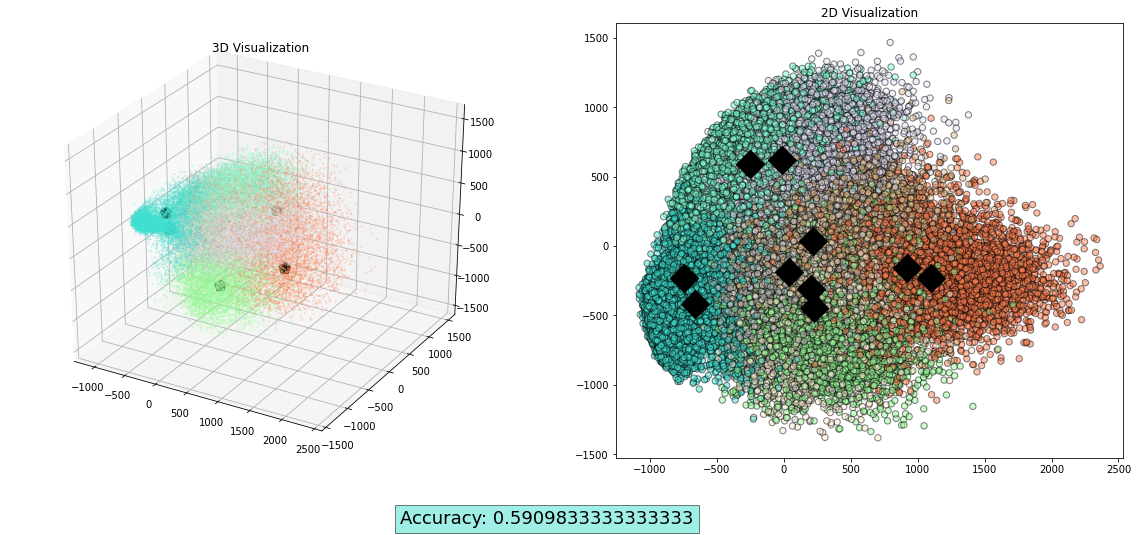

In [17]:
pca = PCA()
pca_res = pca.fit_transform(train_x)
colors = ['coral','turquoise','papayawhip','palegreen','orchid','lavender','lightpink','burlywood','aquamarine','silver']
#Kmeans
kmeans_no_limit = KMeans(n_clusters=10, random_state = 205566292)
kmeans_no_limit_prediction = kmeans_no_limit.fit_predict(pca_res)
centers_no_limit = kmeans_no_limit.cluster_centers_
accuracy_no_limit = accuracy_score(train_y, clusters_true_label(train_y,kmeans_no_limit_prediction))

# merging all points with the 2 centers.
pca_no_limit_res_wcenters = list(pca_res) + list(centers_no_limit)

fig = plt.figure(figsize = (20,8))
#3D
  #PCA
pca_3D = PCA(n_components = 3)
reduced_3D_pca = pca_3D.fit_transform(pca_no_limit_res_wcenters)
centers_3D = reduced_3D_pca[-10:]
points_3D = reduced_3D_pca[:-10]
  #PLOT
ax_3D = fig.add_subplot(1,2,1, projection='3d')
ax_3D.scatter(points_3D[:,0],points_3D[:,1],points_3D[:,2], c=kmeans_no_limit_prediction, cmap = matplotlib.colors.ListedColormap(colors), s=1, alpha = 0.2)
ax_3D.scatter(centers_3D[:,0], centers_3D[:,1], centers_3D[:,2], marker="p", color='k' ,s = 150, alpha=1,edgecolor = "k")
# plt.xlim(-8,8)
# plt.ylim(-8,8)
# ax_3D.set_zlim(-8,8)
ax_3D.set_title("3D Visualization")

#2D
  #PCA
pca_2D = PCA(n_components = 2)
reduced_2D_pca = pca_2D.fit_transform(pca_no_limit_res_wcenters)
centers_2D = reduced_2D_pca[-10:]
points_2D = reduced_2D_pca[:-10]
  #PLOT
ax_2D = fig.add_subplot(1,2,2)
ax_2D.scatter(points_2D[:,0],points_2D[:,1], c=kmeans_no_limit_prediction, cmap = matplotlib.colors.ListedColormap(colors), edgecolor='k', s=40, alpha = 0.5)
ax_2D.scatter(centers_2D[:,0], centers_2D[:,1], marker="D", color='k',s = 400)
ax_2D.set_title("2D Visualization")


plt.figtext(0.5, 0.01, "Accuracy: " + str(accuracy_no_limit), ha="center", fontsize=18, bbox={"facecolor":"turquoise", "alpha":0.5, "pad":5})

# PCA before KMeans
As we can see from the charts above there is no difference between running pca before or after the KMeans application.